In [1]:
import numpy as np
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#the jig is a half-line. It extends infinitely in one direction
#the state includes the displacement (signed distance) from the object to the jig

#   |---> (positive displacement)
#   o   jjjjjj...
# -------->  (coordinate frame attached to object)

# in 1D, you can't rotate the object, so the object frame positive x axis always points to the left
# whether you're plotting in world frame or object frame
#       <---| (negative displacement)
# ..jjjj   o
#  --------> (coordinate frame attached to object)

# HOWEVER, if we attach a coordinate frame to the jig, such that 0 is the boundary, 
# and the negative direction is occupied by jig, then in this coordinate frame, 
# the displacment to the object is always positive
# BUT now we need to encode whether the object frame points left or right,
# since that's the frame you can specify the actions in.
# (I think this is actually less obvious in 1D than in higher dimensions)

# To make the case analogous with the x, y, \theta case consider the following state space

$\left( \mathbf{R}_{+} \times \mathbf{\theta} \right) \cup \mathbf{C}$

$\theta$ in the 1D case takes on one of two values. $\mathbf{C}$ is binary-valued and says whether you're in contact or not. In this 1D case, there is only one contact manifold, and it's zero dimensional.

One departure from the 2D case is that you can't really transition from one $\theta$ value to the other. However, it's still necessary to include it in the state, because in a ($\theta=0^\circ$) world, taking a step in the positive direction increases the displacement from the jig. In a ($\theta=180^\circ$) world, taking a a step in the positive direction *decreases* the displacement.

For comparison, the plannar domain we're considering has the following state space:

$\left( \mathbf{R}_{+} \times \mathbf{R}_{+} \times \mathbf{\theta} \right) 
\cup \left( \mathbf{R}_{+} \times \mathbf{\theta} \right)
\cup \left( \mathbf{R}_{+} \times \mathbf{\theta} \right)
\cup \left( \mathbf{\theta} \right)
\cup \mathbf{C}$

(I'm being informal in writing $\theta$. It really is $SO(2)$)

The space correspond, in order, to:
- the no-contact manifold
- contact with one arm of the jig
- contact with the other arm of the jig
- contact with both arms of the jig
- and the questionably the double-edge contact with the square object is in the corner of the jig

The non-negativity on the real coordinates are applicable when you take the state to be the pose of the object expressed in the jig frame. If you take the pose of the jig expressed in the object frame, then you can't say the coordinates are non-negative

Actually, let us use this state space
$\left( \mathbf{R}_{+} \cup \mathbf{C} \right)\times \mathbf{\theta}$

When we are up against the contact, which of the following is true?
- moving in the positive direction will further push into the contact
- moving in the positive direction will break contact

$\theta$ tells us.

The state space actually is a subset of $\left(\mathbf{R} \cup \mathbf{C} \cup \mathbf{V}\right) \times \mathbf{\theta}$.

But only a subset of those states make sense in the case that the jig is truly a half-line. In the object frame, the jig may have a postive position, but it then must be facing in the negative direction (the jig extends outward toward $+\infty$)

In [3]:
from estimator_state_space import (DirectionStateFactor, MetricStateFactor, 
                                   VoidStateFactor, ContactStateFactor, 
                                   State, StateSpace)

hash Collision: State: +Void: State: +Contact
hash Collision: State: -Void: State: -Contact


In [4]:
state_space = StateSpace()
state_space.to_continuous(state_space.nearest((0.3, -1)))

(0.29999999999999999, -1)

In [5]:
state_space.nearest((0.1, -1))

State: -Metric: 97

In [6]:
state_space.interpolate((0.656, -1))

[(0.40000000000000002, State: -Metric: 152),
 (0.59999999999999998, State: -Metric: 153)]

In [7]:
list(state_space.states)[0:9], list(state_space.states)[::25]

([State: +Metric: 2,
  State: +Metric: 29,
  State: +Metric: 23,
  State: +Metric: 14,
  State: +Metric: 19,
  State: +Metric: 50,
  State: +Metric: 5,
  State: +Metric: 71,
  State: -Metric: 176],
 [State: +Metric: 2,
  State: -Metric: 95,
  State: +Metric: 11,
  State: +Metric: 75,
  State: -Metric: 126,
  State: -Metric: 149,
  State: +Metric: 24,
  State: +Metric: 57])

In [8]:
state_space.manifold_0d

{State: -Void, State: -Contact, State: +Contact, State: +Void}

In [9]:
import estimator_belief
Belief = estimator_belief.belief_factory(state_space)

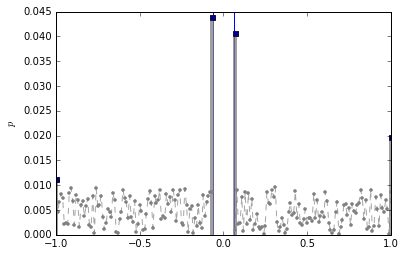

In [10]:
def setup_belief_plot(ax=None):
    if ax is None:
        ax = plt.gca()
    
    ax.axhline(0.0)
    ax.axvline(state_space.object_half_width)
    ax.axvline(-state_space.object_half_width)
    ax.set_ylabel(r"$p$")
    return ax

ax = setup_belief_plot()
b = Belief()
b.something()
b.plot(ax);

In [11]:
 b.metric_mean()

-0.038849065630407534

In [12]:
def ideally_identity(xd):
    # interpolate a continuous point onto the metric part
    # convert to a distribution over the metric states (a Belief)
    # take the mean of the belief
    affine_combo = state_space.interpolate(xd)
    affine_combo = [(a,Belief(delta=b)) for (a,b) in affine_combo]
    return Belief.blend(affine_combo).metric_mean()

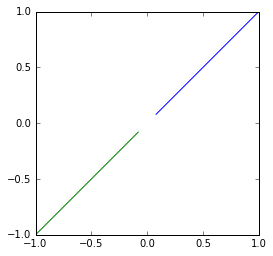

In [13]:
#a sort of unit test. the line should be straight with slope=1
x = np.linspace(0.08,0.99,1000) #0.07 endpoint is an edge case handled in the interpolation code.
y = map(ideally_identity, [(d, -1) for d in x])
plt.plot(x,y)
plt.gca().set_aspect(1.0)

x = np.linspace(0.08,0.99,1000) #-0.07 endpoint is an edge case handled in the interpolation code.
y = map(ideally_identity, [(d, 1) for d in -x])
plt.plot(-x,y)
plt.gca().set_aspect(1.0)


In [14]:
#another sort of unit test
#check that all delta distributions are normalized
etas = [Belief(delta=s).sum() for s in state_space.states]

if not np.all([np.isclose(eta, 1.0) for eta in etas]):
    print("Test Fail")

    for s in state_space.states:
        if not np.isclose(Belief(delta=s).sum(), 1.0):
            print(s)

In [15]:
# another unit test
# check tha the to_continuous and interpolate functions are self-consistent
# note that the errors being printed are actually desirable. absorb into contact or void states
for state in state_space.states:
    cont = state_space.to_continuous(state)
    state_again_interp = state_space.interpolate(cont)
    
    state_again_coeffs = np.array([coeff for (coeff, _s) in state_again_interp])
    l = np.where(state_again_coeffs==1.0)[0]
    
    state_again = state_again_interp[l[0]][1] if len(l) == 1 else None
    
    if state_again != state:
        print("Error", state, cont, state_again, state_again_interp)


('Error', State: +Metric: 93, (-0.070000000000000007, 1.0), State: +Contact, [(1.0, State: +Contact)])
('Error', State: -Metric: 187, (1.0, -1.0), State: -Void, [(1.0, State: -Void)])
('Error', State: +Metric: 0, (-1.0, 1.0), State: +Void, [(1.0, State: +Void)])
('Error', State: -Metric: 94, (0.070000000000000007, -1.0), State: -Contact, [(1.0, State: -Contact)])


In [16]:
state_space.interpolate((state_space.extent+state_space.d_xy/4.0, -1.0))

[(1.0, State: -Void)]

In [17]:
b = Belief(delta=State( DirectionStateFactor(1), ContactStateFactor()))

for s in state_space.states:
    if b.prob(s) != 0:
        print(s, b.prob(s))

(State: +Contact, 1.0)


In [18]:
b = Belief()
b.p[State(DirectionStateFactor(1),ContactStateFactor())] = 1

In [19]:
for s in state_space.states:
    if b.prob(s) != 0:
        print(s, b.prob(s))

(State: +Contact, 1)


In [20]:
import estimator_transition_model

GuardedVelocity = estimator_transition_model.guarded_velocity_factory(state_space, Belief)

In [21]:
action = GuardedVelocity(0.0005)

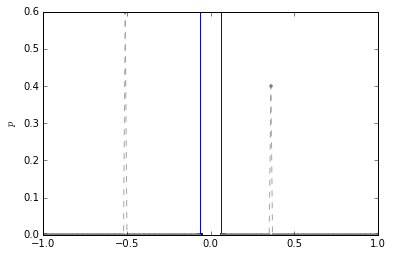

In [22]:
ss = list(state_space.states)

b = Belief.blend([ (0.6, Belief(delta=ss[31])), 
                    (0.4, Belief(delta=ss[71])),])

ax = setup_belief_plot()
b.plot(ax);

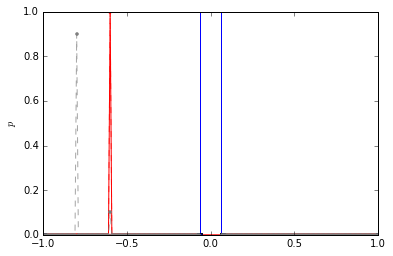

In [23]:
ax = setup_belief_plot()
state = state_space.nearest((-0.6, 1.0))
b = Belief(delta=state)
b.plot(ax, p_metric_kwargs=dict(color='red'))

b1 = GuardedVelocity(0.2).propogate_state(state, dt=1.0)
b1.plot(ax);

try:
    b.metric_mean(), b1.metric_mean()
except ValueError as e:
    print(e)

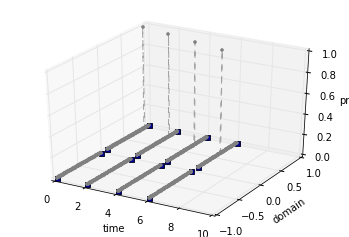

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.set_xlim3d(0, 10)
ax.set_ylim3d(-1, 1)
ax.set_zlim3d(0, 1)
ax.set_zlabel("prob")
ax.set_ylabel("domain")
ax.set_xlabel("time")


Belief(delta=state_space.nearest((0.9, -1.0))).plot(ax, all_kwargs=dict(zs=0, zdir="x"));
Belief(delta=state_space.nearest((0.8, -1.0))).plot(ax, all_kwargs=dict(zs=2, zdir="x"));
Belief(delta=state_space.nearest((0.7, -1.0))).plot(ax, all_kwargs=dict(zs=4, zdir="x"));
Belief(delta=state_space.nearest((0.6, -1.0))).plot(ax, all_kwargs=dict(zs=6, zdir="x"));

In [25]:
b.something()

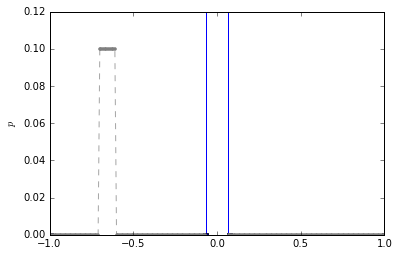

In [26]:
#uniform-ish belief
for s in state_space.manifold_0d:
    b.p[s] = 0#1.0

for s in state_space.manifold_1d:
    b.p[s] = 0#10.0

for s in range(30,40):
    b[State(DirectionStateFactor(1), MetricStateFactor(s))] = 20.0

    
b.normalize()

#b = Belief(delta= state_space.nearest((0.9, -1.0)))

ax = setup_belief_plot()
b.plot(ax);

(0.00082500000000000173, -0.65500000000000025)

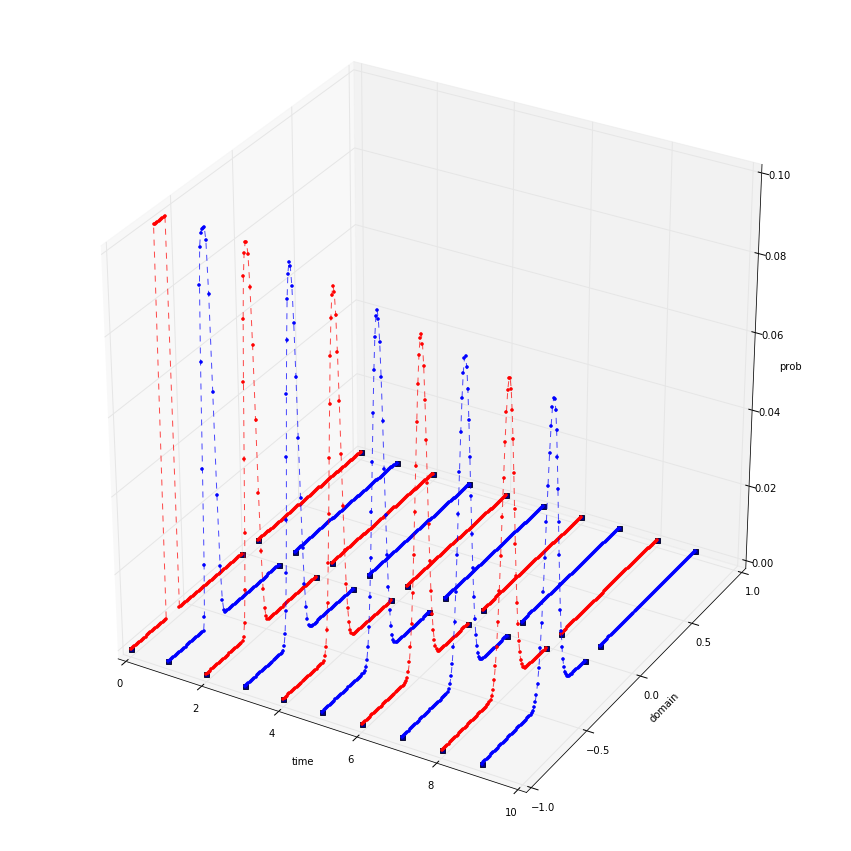

In [27]:
fig = plt.figure()
fig.set_size_inches(15,15)
ax = fig.gca(projection='3d')

ax.set_xlim3d(0, 10)
ax.set_ylim3d(-1, 1)
#ax.set_zlim3d(0, 0.5)
ax.set_zlabel("prob")
ax.set_ylabel("domain")
ax.set_xlabel("time")

bi = b
zlim = 0.0
for i in range(10):
    bi.plot(ax, all_kwargs=dict(zs=i, zdir="x"), p_metric_kwargs=dict(color=['r', 'b'][i%2], linestyle=""));
    zlim = max(zlim, max(b.p.values())) # matplotlib autoscale doesn't work: https://github.com/matplotlib/matplotlib/issues/5742
    for j in range(10):
        bi = GuardedVelocity(-0.2).propogate_belief(bi, dt=0.016)

ax.set_zlim3d(0, zlim)

#ax.set_title("belief in object frame")
#ax.set_xlabel("displacement of jig from object, expressed in object frame")
#ax.semilogy()
b.metric_variance(), b.metric_mean()

In [28]:
import estimator_observation_model

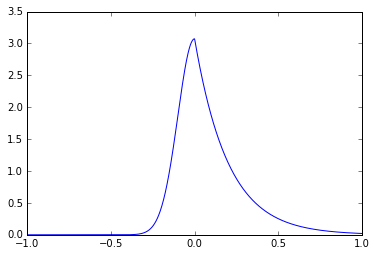

In [29]:
pdf = estimator_observation_model.exp_norm_piecewise(0.2,0.02)
x = np.linspace(-1,1,1000)
y = pdf(x)
plt.plot(x,y)
#plt.gca().semilogy()

In [30]:
displacement_observation_distribution = estimator_observation_model.displacement_observation_distribution_factory(state_space)


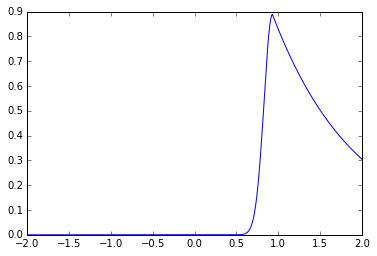

In [31]:
pdf = displacement_observation_distribution(
        State(DirectionStateFactor(-1), VoidStateFactor()),
        State(DirectionStateFactor(-1), ContactStateFactor()))

x = np.linspace(-2,2,1000)
y = pdf(x)
plt.plot(x,y)


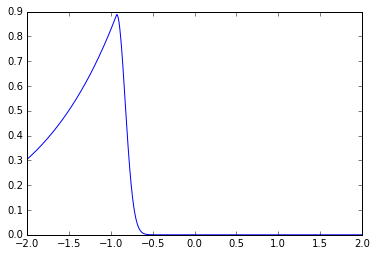

In [32]:
pdf = displacement_observation_distribution(
    State(DirectionStateFactor(1), VoidStateFactor()),
    State(DirectionStateFactor(1), ContactStateFactor()))

x = np.linspace(-2,2,1000)
y = pdf(x)
plt.plot(x,y)


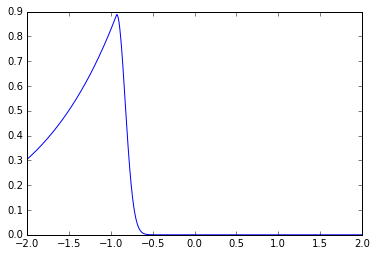

In [33]:
pdf = displacement_observation_distribution(
        State(DirectionStateFactor(-1), ContactStateFactor()),
        State(DirectionStateFactor(-1), VoidStateFactor()))

x = np.linspace(-2,2,1000)
y = pdf(x)
plt.plot(x,y)


True
False


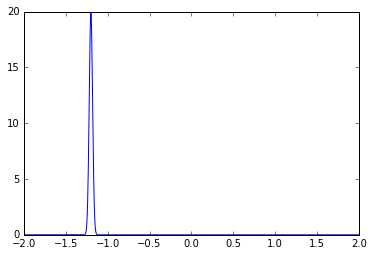

In [34]:
from_state = State(DirectionStateFactor(-1), MetricStateFactor(3))
to_state = State(DirectionStateFactor(-1), MetricStateFactor(110))

print(to_state in state_space.manifold_1d)
print(from_state in state_space.manifold_1d)

pdf = displacement_observation_distribution(from_state, to_state)

x = np.linspace(-2,2,1000)
y = pdf(x)
plt.plot(x,y)


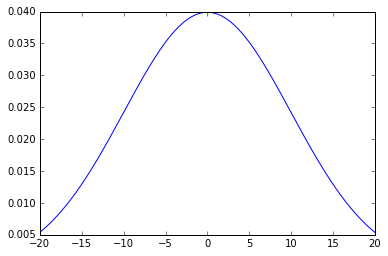

In [35]:
from_state = State(DirectionStateFactor(-1), VoidStateFactor())
to_state = State(DirectionStateFactor(-1), VoidStateFactor())

pdf = displacement_observation_distribution(from_state, to_state)

x = np.linspace(-20,20,1000)
y = pdf(x)
plt.plot(x,y)


In [36]:
force_observation_distribution = estimator_observation_model.force_observation_distribution_factory(state_space)

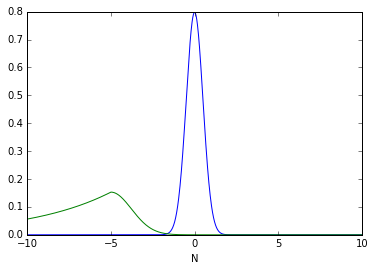

In [37]:
p = force_observation_distribution(State(DirectionStateFactor(1), MetricStateFactor(3)), GuardedVelocity(1.0))

x = np.linspace(-10,10,1000)
y = p(x)
plt.plot(x,y)
plt.xlabel("N")

p = force_observation_distribution(State(DirectionStateFactor(1), ContactStateFactor()), GuardedVelocity(1.0))

x = np.linspace(-10,10,1000)
y = p(x)
plt.plot(x,y)
plt.xlabel("N")

#plt.semilogy()

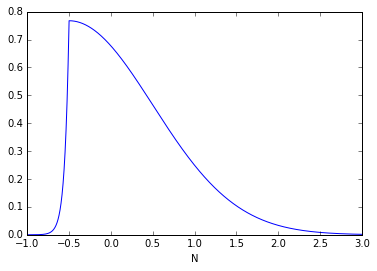

In [38]:
# drag force as you're sliding along a surface, maybe
f = estimator_observation_model.exp_norm_piecewise(0.05, 2.0)
g = lambda(x): f(-(x-(-0.5)))

x = np.linspace(-1,3,1000)
y = g(x)
plt.plot(x,y)
plt.xlabel("N")


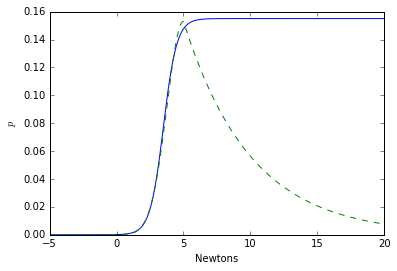

In [39]:
# contact force after going into object
f = estimator_observation_model.exp_norm_piecewise(5, 3)
g = lambda(x): f((x-(5)))

x = np.linspace(-5,20,1000)
y = 0.155 / (1 + np.exp(-2* (x-3.5)))
plt.plot(x,y)
plt.plot(x,g(x),'--')
plt.xlabel("Newtons")
plt.ylabel(r"$p$")

In [40]:
import estimator

estimator_object = estimator.Estimator(state_space)
obs_act_update = estimator_object.obs_act_update

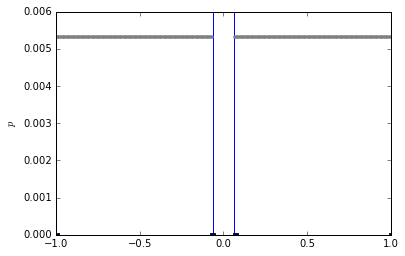

In [41]:
#uniform-ish belief
b = Belief()

if True:
    for s in state_space.manifold_0d:
        b.p[s] = 0.0

    for s in state_space.manifold_1d:
        b.p[s] = 1.0
    
else:
    for s in range(30,40):
        b[State(DirectionStateFactor(1), MetricStateFactor(s))] = 20.0

b.normalize()

#b = Belief(delta= state_space.nearest((0.9, -1.0)))

ax = setup_belief_plot()
b.plot(ax);

In [42]:
%load_ext snakeviz

In [43]:
action = GuardedVelocity(-state_space.d_xy*5)
duration = 1.0
nominal_movement = action.velocity * duration

In [44]:
%%snakeviz
b_prior = action.propogate_belief(b, dt=duration)

b_posts = {}
b_posts["init"] = b
b_posts["prior"] = b_prior

 
*** Profile stats marshalled to file u'/var/folders/ps/88v5jmwd5q7c9k36f7mkn0q40000gn/T/tmp7gw5zx'. 


In [45]:
# %%snakeviz
nominal_force = 3.0*np.sign(action.velocity)
for f_name, f_o in zip(["z","p",None], [0.0, nominal_force, None]):
    for d_name, d_o in zip(["z","p",None], [0.0, nominal_movement, None]):
        print(f_name, d_name)
        b_post = obs_act_update(
                b, 
                displacement_observation=d_o,
                force_observation=f_o,
                action=action,
                duration=duration)
        b_posts[(f_name, d_name)] = b_post

('z', 'z')
('z', 'p')
('z', None)
('p', 'z')
('p', 'p')
('p', None)
(None, 'z')
(None, 'p')
(None, None)


In [46]:
%%timeit
b_post = obs_act_update(
        b, 
        displacement_observation=0.0,
        force_observation=0.0,
        action=action,
        duration=duration)

100 loops, best of 3: 14.8 ms per loop


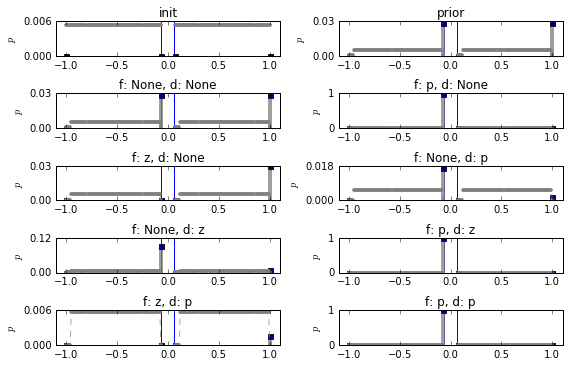

In [47]:
fig = plt.gcf()
fig.set_size_inches((8.0, 8.0))

for i, k in enumerate(["init", "prior", (None, None), ("p", None), ("z", None), (None, "p"), 
                       (None, "z"), ("p", "z"), ("z", "p"), ("p", "p")]):
    ax = fig.add_subplot(8, 2, i+1)
    setup_belief_plot(ax)
    
    if type(k) is tuple:
        ax.set_title("f: %s, d: %s"%(k[0], k[1]))
    else:
        ax.set_title(k)
    
    b_posts[k].plot(ax)
    ax.set_xlim(-1.1, 1.1)
    ax.set_yticks([ax.get_yticks()[0], ax.get_yticks()[-1]])

fig.tight_layout()

(-1.1, 1.1)

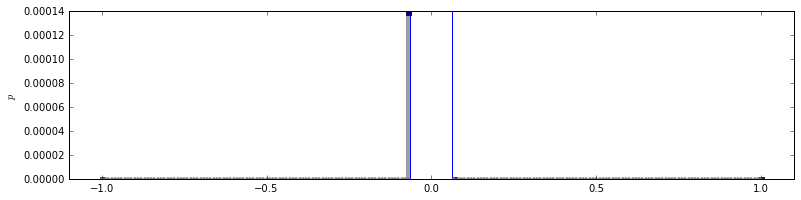

In [48]:
force_observation = -40
displacement_observation = None
bsao = estimator_object.distribution_over_next_state_given_sao(
        State(DirectionStateFactor(1), ContactStateFactor()), 
        action, 
        force_observation, 
        displacement_observation, 
        duration)
 
plt.gcf().set_size_inches((13.0, 3.0))
setup_belief_plot(plt.gca())
bsao.plot(plt.gca());
plt.gca().set_xlim(-1.1, 1.1)

In [49]:
def force_distribution_marginalize_out_next_state(state, action, duration, x_values):
    one_step_belief = action.propogate_state(state, dt=duration)
    
    output = np.zeros((len(x_values),))
    
    for next_state in one_step_belief.nonzero_states():
        output += one_step_belief[next_state] * force_observation_distribution(next_state, action.velocity)(x_values)

    return output

def force_distribution_belief(belief, action, duration, x_values):
    output = np.zeros((len(x_values),))
    
    for state in belief.nonzero_states():
        output += belief[state] * force_distribution_marginalize_out_next_state(state, action, duration, x_values)
    
    return output

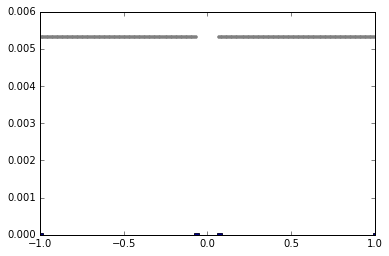

In [50]:
b_posts["init"].plot(plt.gca());

Prob mass: 0.997975722081


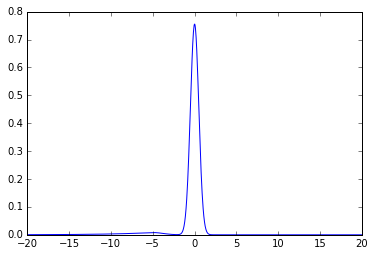

In [51]:
xv = np.linspace(-20, 20, 1000)
yv = force_distribution_belief(b_posts["prior"], action, duration, xv)
plt.plot(xv,yv)
print("Prob mass: %s"%scipy.integrate.cumtrapz(yv, xv)[-1])

In [52]:
# because force depends only on action and next state, we can plot the likelihood in the same way we plot beliefs
# (if it depended on previous state, that wouldn't be possible)

likelihood = Belief() # this is not a Belief. It is not a distribution.
for next_state in state_space.states:
    p_o_given_as = force_observation_distribution(next_state, action.velocity)(nominal_force)
    likelihood[next_state] = p_o_given_as


[]

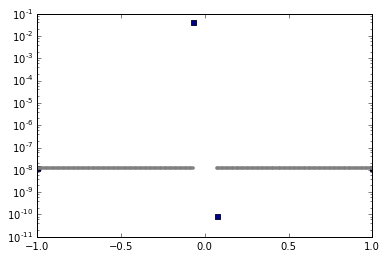

In [53]:
likelihood.plot(plt.gca());
plt.gca().semilogy()

In [54]:
%%timeit
bparse = Belief()
bparse.from_json_string(b.to_json_string())
bdiff = Belief.diff(b, bparse)
bdiff.sparsify()
if(len(bdiff.p)) != 0:
    print("test fail")

1000 loops, best of 3: 965 µs per loop
